In [ ]:
!pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


# 1. Módulo `stream` - encapsular datasets
Permite encapsular diferentes fontes de datasets comuns e utilizar no formato de fluxo de dados, iterarando a cada instância.
Nesse exemplo usei o `stream.iter_sklearn_dataset`

In [ ]:
from sklearn import datasets
from river import stream

In [ ]:
diabetes = datasets.load_diabetes() # dataset do sklearn a ser encapsulado

In [ ]:
for x,y in stream.iter_sklearn_dataset(diabetes): # o método cria um generator
  print(x)
  print(y)
  break

{'age': 0.038075906433423026, 'sex': 0.05068011873981862, 'bmi': 0.061696206518683294, 'bp': 0.0218723855140367, 's1': -0.04422349842444599, 's2': -0.03482076283769895, 's3': -0.04340084565202491, 's4': -0.002592261998183278, 's5': 0.019907486170462722, 's6': -0.01764612515980379}
151.0


### 1.1 Exemplo mais genérico: utilizando o repositório UCI
O método `iter_pandas` adapta o dataset para o tipo adequado utilizado na river (gerador).

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets["class"]

In [ ]:
for x,yi in stream.iter_pandas(X,y): # simulando fluxo de dados
  print(x)
  print(yi)
  break

{'sepal length': 5.1, 'sepal width': 3.5, 'petal length': 1.4, 'petal width': 0.2}
Iris-setosa


# 2. Treinamento básico (sem tratamento de dados)
Exemplos de treinamento sem utilizar os pipelines de tratamento de dados

## 2.1 Treinar modelo simples de regressão
Nesse exemplo o tratamento nos dados não foi feito para manter simples

In [ ]:
from river.tree import HoeffdingTreeRegressor
from river import evaluate
from river import metrics

In [ ]:
tree = HoeffdingTreeRegressor() # Versão da Hoeffding Tree para tarefas de regressão
rmse = metrics.RMSE() # A river tem classes prontas para boa parte das métricas comuns

In [ ]:
# fetch dataset
wine = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine.data.features
y = wine.data.targets["quality"]

`learn_one` - método para ajustar vendo apenas 1 única instância por vez
<br>
`predict_one` - métodos para previsão de 1 único valor target

In [ ]:
for x,yi in stream.iter_pandas(X, y):
  # Este é o framework comum de validação em fluxo de dados
  # Test-then-train
  # Para evitar vazamento, primeiro o modelo faz a predição e atualiza o erro
  # Por fim, o modelo ajusta os parâmetros usando essa instância

  # 1. Teste
  y_pred = tree.predict_one(x)
  # 2. Atualiza métrica
  rmse.update(yi, y_pred)
  # 3. Ajuste
  tree.learn_one(x, yi)

In [ ]:
print(rmse)

RMSE: 3.406538


### 2.1.1 Outra forma de avaliar o modelo é usando o `progressive_val_score` do módulo `evaluate`
Ele aplica o framework test-then-train e permite printar a métrica progressivamente, conforme os dados vão sendo iterados.

In [ ]:
evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y), # Aqui a argumento precisa ser um Dataset da river,
                                      # Para isso o dataset externo precisa ser encapsulado
                                      # usando o módulo stream
    model=tree,
    metric=rmse,
    print_every=500, # Parâmetro que controla a frequência dos prints
    show_time=True,
    show_memory=True,
)

[500] RMSE: 3.288701 – 00:00:00 – 1.59 MiB
[1,000] RMSE: 3.182332 – 00:00:00 – 1.6 MiB
[1,500] RMSE: 3.086531 – 00:00:01 – 1.66 MiB
[2,000] RMSE: 3.000148 – 00:00:01 – 2.01 MiB
[2,500] RMSE: 2.922183 – 00:00:02 – 2.25 MiB
[3,000] RMSE: 2.850748 – 00:00:02 – 2.25 MiB
[3,500] RMSE: 2.78368 – 00:00:03 – 2.65 MiB
[4,000] RMSE: 2.721495 – 00:00:03 – 2.79 MiB
[4,500] RMSE: 2.663095 – 00:00:04 – 2.73 MiB
[5,000] RMSE: 2.60939 – 00:00:05 – 2.89 MiB
[5,500] RMSE: 2.558722 – 00:00:05 – 3.03 MiB
[6,000] RMSE: 2.51042 – 00:00:06 – 3.16 MiB
[6,497] RMSE: 2.465282 – 00:00:06 – 3.2 MiB


RMSE: 2.465282

### 2.1.2 Gerar gráficos
O `iter_progressive_val_score` é útil para gerar gráficos pois é um generator

In [ ]:
import matplotlib.pyplot as plt

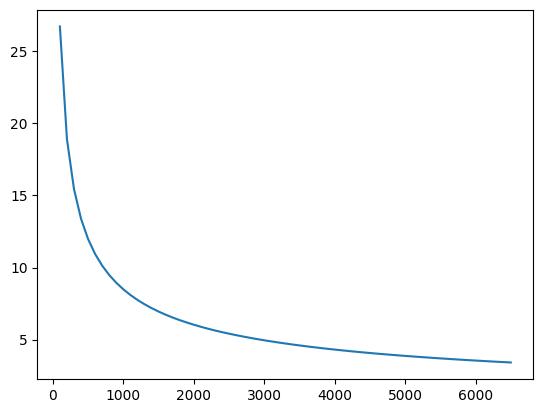

In [ ]:
# Listas para armazenar o histórico da performance
steps= []
results = []

# Retorna um generator de dicionário. As chaves são Step e o nome da métrica
# Exemplo: {"Step": 1, "RMSE": 1.2}, {"Step": 2, "RMSE": 1.1}
progressive_validation = evaluate.iter_progressive_val_score(
    dataset=stream.iter_pandas(X, y),
    model=HoeffdingTreeRegressor(),
    metric=metrics.RMSE(),
    step=100
)

for val in progressive_validation: # Usando o generator
    steps.append(val.get("Step"))
    results.append(val.get("RMSE").get())

plt.plot(steps, results);

### 2.1.2 O método `draw`: visualizar a árvore

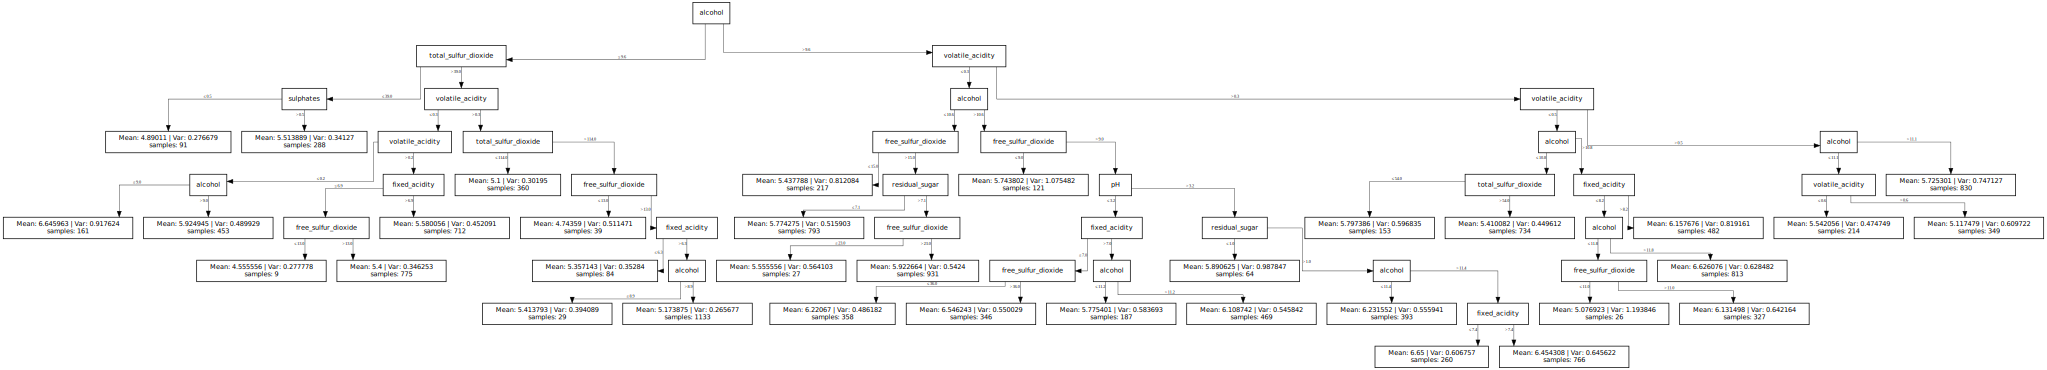

In [ ]:
tree.draw()

## 2.2 Treinar modelo simples de classificação

In [ ]:
from river.tree import HoeffdingTreeClassifier

In [ ]:
tree = HoeffdingTreeClassifier() # Versão da Hoeffding Tree para tarefas de regressão
acc = metrics.Accuracy()

In [ ]:
# fetch dataset
iris = fetch_ucirepo(id=53)

# data (as pandas dataframes)
X = iris.data.features
y = iris.data.targets["class"]

In [ ]:
evaluate.progressive_val_score(
    dataset=stream.iter_pandas(X, y), # Aqui a argumento precisa ser um Dataset da river,
                                      # Para isso o dataset precisa ser encapsulado
                                      # como foi feito nos casos anteriores
    model=tree,
    metric=acc,
    print_every=20,
    show_time=True,
    show_memory=True,
)

[20] Accuracy: 100.00% – 00:00:00 – 22.62 KiB
[40] Accuracy: 100.00% – 00:00:00 – 22.62 KiB
[60] Accuracy: 96.61% – 00:00:00 – 36.42 KiB
[80] Accuracy: 97.47% – 00:00:00 – 36.42 KiB
[100] Accuracy: 97.98% – 00:00:00 – 36.42 KiB
[120] Accuracy: 95.80% – 00:00:00 – 49.96 KiB
[140] Accuracy: 94.96% – 00:00:00 – 49.96 KiB
[150] Accuracy: 95.30% – 00:00:00 – 49.96 KiB


Accuracy: 95.30%

# 3. Treinamento com tratamento de dados (Pipeline)